In [1286]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Author : Patrice Bechard BECP30119404
IFT6269 - Probabilistic Graphical Models
Homework 3 - Hidden Markov Model Implementation
November 21th, 2017
"""

'\nAuthor : Patrice Bechard BECP30119404\nIFT6269 - Probabilistic Graphical Models\nHomework 3 - Hidden Markov Model Implementation\nNovember 21th, 2017\n'

In [1287]:
# Importing modules

%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as col
import sys
from matplotlib.patches import Ellipse


Populating the interactive namespace from numpy and matplotlib


In [1288]:
# Defining initial prob, transition matrix,
# means and covariance matrices of clusters (given)

np.random.seed(6269)

MEAN = np.array([[-2.0344,  4.1726],
                 [ 3.9779,  3.7735],
                 [ 3.8007, -3.7972],
                 [-3.0620, -3.5345]])

COV = np.array([[[2.9044,  0.2066],
                 [0.2066,  2.7562]],
                [[0.2104,  0.2904],
                 [0.2904, 12.2392]],
                [[0.9213,  0.0574],
                 [0.0574,  1.8660]],
                [[6.2414,  6.0502],
                 [6.0502,  6.1825]]])

PI = np.ones(MEAN.shape[0]) / MEAN.shape[0]

TRANSIT_MATRIX = np.array([[1/2, 1/6, 1/6, 1/6],
                           [1/6, 1/2, 1/6, 1/6],
                           [1/6, 1/6, 1/2, 1/6],
                           [1/6, 1/6, 1/6, 1/2]])


In [1289]:
class K_Means:
    """K-means algorithm for clustering unlabeled data"""
    
    def __init__(self, n_states, train_data, init=False):
        """
        Parameters
        ----------
        n_classes : integer
            number K of clusters to separate data
        n_dims : integer
            number of dimensions for the data
        train_data : array-like, shape = [n_examples, n_dims]
            data used to train the clustering algorithm
        initializing : boolean
            parameter is True if the algorithm is used to initialize cluster
            means for another clustering algorithm
        """
        self.n_states = n_states
        self.n_pts = train_data.shape[0]
        self.n_dims = train_data.shape[1]
        self.train_data = train_data
        self.trained = False
        self.init = init
        
        self._init_cluster_means()         #initializing self.means randomly
        self.z = np.zeros(self.n_pts).astype('int')
        
    def train(self, n_iter=None):
        """
        Training the algorithm until convergence of objective function
        or for a certain number of iterations
        Parameters
        ----------
        n_iter : int (or None)
            Number of iterations to train the K-means algorithm.
            If it is None, we train the k-means algorithm
            until convergence.            
        
        Returns
        ----------
        z : array-like, shape = [n_examples,n_classes]
            array of onehot vectors indicating to which cluster each data
            point is assigned
        mean : array-like, shape = [n_classes,n_dims]
            array containing the cluster mean for each class
        """
        
        if n_iter is None:
            
            # initial values for convergence condition
            old_val = 1e9                       
            new_val = 1e8       
            
            while np.abs(old_val - new_val) > 0.0001:    #convergence criterion
                #E step
                for i in range(self.n_pts):
                    dist = np.sum(np.abs(self.train_data[i] - self.mean), axis=1)
                    self.z[i] = np.argmin(dist)
                    
                #M step
                update_mean = np.zeros_like(self.mean)
                for i in range(self.n_pts):
                    update_mean[self.z[i]] += self.train_data[i]
                     
                self.mean = np.divide(update_mean.T, np.bincount(self.z)).T
            
                old_val = new_val
                new_val = self._compute_objective()
        else:
            for i in range(n_iter):
                #E step
                for i in range(self.n_pts):
                    dist = np.sum(np.abs(self.train_data[i] - self.mean), axis=1)
                    self.z[i] = np.argmin(dist)
                    
                #M step
                update_mean = np.zeros_like(self.mean)
                for i in range(self.n_pts):
                    update_mean[self.z[i]] += self.train_data[i]
                     
                self.mean = np.divide(update_mean.T, np.bincount(self.z)).T       
        
        self.trained = True
        
        if self.init:                #algorithm used to initialize values for another algorithm
            return self.z, self.mean
    
    def show_clusters(self, tag=None):
        
        if self.trained:
            """Show data, cluster means and cluster assignments""" 
            colors = ['r','g','b','y']
            datacolor = []
            datalabels = np.argmax(self.z,axis=1)
            for i in range(len(datalabels)):
                datacolor.append(colors[datalabels[i]])
            objective = self._compute_objective()
            
            plt.scatter(self.train_data[:,0], self.train_data[:,1],alpha=0.3,marker='.',c=datacolor)
            plt.scatter(self.mean[:,0], self.mean[:,1],marker='X',s=150,facecolor=colors, edgecolors='k',lw=2)
            plt.xlabel('feature 1')
            plt.ylabel('feature 2')
            plt.title('Final position of cluster means with associated clusters (J=%.2f)'%objective)
            if tag is not None:
                plt.savefig('latex/figures/final_kmeans_%02d.png'%tag)
            print('Value of objective function at end of convergence : %.2f'%objective)

        else:
            """only show data points and randomly set cluster means"""
            plt.scatter(self.train_data[:,0], self.train_data[:,1],marker='.', alpha=0.3)
            plt.scatter(self.mean[:,0], self.mean[:,1],marker='X',s=150, edgecolors='k',lw=2)
            plt.xlabel('feature 1')
            plt.ylabel('feature 2')
            plt.title('Initial cluster means position')
            if tag is not None:
                plt.savefig('latex/figures/init_kmeans_%02d.png'%tag) 

        plt.show()
        plt.clf()
        
    def _init_cluster_means(self):
        """Randomly initializing cluster means within domain where data spreads"""
        self.mean = np.zeros((self.n_states, self.n_dims))
        x_span = np.max(self.train_data[:,0])-np.min(self.train_data[:,0])
        y_span = np.max(self.train_data[:,1])-np.min(self.train_data[:,1])
        
        for i in range(self.n_states):
            x_comp = x_span * np.random.random() + np.min(self.train_data[:,0])
            y_comp = y_span * np.random.random() + np.min(self.train_data[:,1])

            self.mean[i] = np.array([x_comp,y_comp])
        
    def _compute_objective(self):
        """Computes objective function which we try to minimize"""
        objective = 0
        for i in range(self.n_pts):
            objective += np.sum(np.abs(self.train_data[i] - \
                                       self.mean[self.z[i]])**2)
        return objective
            
    def log_likelihood(self, data):
        """Computes objective function which we try to minimize"""
        objective = 0
        n_pts = data.shape[0]
        
        #E step
        for i in range(n_pts):
            dist = np.sum(np.abs(data[i] - self.mean), axis=1)
            objective += np.sum(np.abs(data[i] - self.mean[argmin(dist)])**2)
            
        return objective / n_pts

In [1290]:
class GMM:
    """Gaussian mixture model using the EM algorithm to cluster data for unsupervised learning"""
    
    def __init__(self, n_states, train_data, cov_type):
        """
        Parameters
        ----------
        n_classes : integer
            number K of clusters to separate data
        n_dims : integer
            number of dimensions for the data
        train_data : array-like, shape = [n_examples, n_dims]
            data used to train the clustering algorithm
        cov_type : string
            defines the type of covariance matrix used to fit the data.
            Can be either 'isotropic' or 'full'.
        """
        self.n_states = n_states
        self.n_pts = train_data.shape[0]
        self.n_dims = train_data.shape[1]
        self.train_data = train_data
        self.cov_type = cov_type
        self.trained = False
        
        #Initialization pi and cluster means using k-means
        kmeans_init = K_Means(self.n_states, self.train_data, init=True)
        self.z, self.mean = kmeans_init.train()
        
        self.pi = np.bincount(self.z) / self.n_pts
        
        #initialize as large spherical gaussian
        self.cov = np.array([10 * np.eye(self.n_dims) \
                             for i in range(self.n_states)])

    def train(self, n_iter=None):
        """
        Training the algorithm until convergence of objective function
        or for a certain number of iterations
        Parameters
        ----------
        n_iter : int (or None)
            Number of iterations to train the K-means algorithm.
            If it is None, we train the k-means algorithm
            until convergence.  
            
        Returns
        ----------
        z : array-like, shape = [n_examples,n_classes]
            array of onehot vectors indicating to which cluster each data
            point is assigned
        mean : array-like, shape = [n_classes,n_dims]
            array containing the cluster mean for each class
        """
        
        old_val = 1e9
        new_val = 1e8
        
        if n_iter is None:
            while np.abs(old_val - new_val) > 0.0001:
                #E step
                #computing weights tau_i,j
                self.weights = self._compute_weights(self.train_data)    

                #M step
                #updating pi, mean and covariance matrix
                self._update_pi()
                self._update_mean()
                self._update_cov()

                old_val = new_val
                new_val = self._compute_objective()
        else:
            for i in range(n_iter):
                #E step
                #computing weights tau_i,j
                self.weights = self._compute_weights(self.train_data)    

                #M step
                #updating pi, mean and covariance matrix
                self._update_pi()
                self._update_mean()
                self._update_cov()                

        self.trained = True

    def show_clusters(self,iter):
        if self.trained:
            """
            Show data, cluster means and cluster assignments with ellipse representing 95.45%
            of the mass of the Gaussian distribution for each cluster after training.
            """
            f, ax = plt.subplots()
            colors = ['r','g','b','y']
            datalabels = np.argmax(self.weights, axis=1)
            datacolor = []
            for i in range(len(datalabels)):
                datacolor.append(colors[datalabels[i]])
            ax.scatter(self.train_data[:,0], self.train_data[:,1],marker='.', alpha=0.5,c=datacolor)
            ax.scatter(self.mean[:,0], self.mean[:,1],marker='X',s=150,facecolor=colors, edgecolors='k',lw=2)
            for j in range(self.n_states):
                plot_cov_ellipse(self.cov[j], self.mean[j], ax=ax, alpha=0.2, color=colors[j])
            ax.set_xlabel('feature 1')
            ax.set_ylabel('feature 2')
            if self.cov_type == 'isotropic':
                ax.axis('equal')
            ax.set_title('Final cluster means position')
            plt.savefig('latex/figures/final_%s_%02d.png'%(self.cov_type,iter))
            plt.show()
            plt.clf()
        else:
            """
            Show data, cluster means and cluster assignments for each cluster after initialization
            using k-means algorithm.
            """
            colors = ['r','g','b','y']
            datacolor = []
            datalabels = np.argmax(self.z,axis=1)
            for i in range(len(datalabels)):
                datacolor.append(colors[datalabels[i]])
            plt.scatter(self.train_data[:,0], self.train_data[:,1],marker='.', alpha=0.5,c=datacolor)
            plt.scatter(self.mean[:,0], self.mean[:,1],marker='X',s=150,facecolor=colors, edgecolors='k',lw=2)
            plt.xlabel('feature 1')
            plt.ylabel('feature 2')
            if self.cov_type == 'isotropic':
                plt.axis('equal')
            plt.title('Initial cluster means position')
            plt.savefig('latex/figures/init_%s_%02d.png'%(self.cov_type,iter))
            plt.show()
            plt.clf()
            
    def _compute_weights(self, data):
        """Computing weights of each class for each data point"""
        numerator = np.zeros((len(data), self.n_states))
        for i in range(data.shape[0]):
            for j in range(self.n_states):
                numerator[i,j] = self.pi[j] * gaussian(data[i],
                                                       self.mean[j],
                                                       self.cov[j])
        denominator = np.sum(numerator,axis=1)      
        return np.divide(numerator.T,denominator).T
    
    def _update_pi(self):
        """Updating the parameter pi"""
        self.pi = np.sum(self.weights,axis=0) / self.n_states
            
    def _update_mean(self):      
        """Updating the cluster means for each class"""
        for j in range(self.n_states):
            self.mean[j] = np.matmul(self.weights[:,j],self.train_data)
        self.mean = np.divide(self.mean.T,np.sum(self.weights,axis=0)).T
            
    def _update_cov(self):
        """Updating the covariance matrix depending on the cov_type"""
        if self.cov_type == 'isotropic':
            self.cov = np.zeros_like(self.cov)
            sigma = np.zeros(self.n_states)
            for j in range(self.n_states):
                for i in range(self.n_pts):
                    sigma[j] += self.weights[i,j] * np.dot(self.train_data[i]-self.mean[j],
                                                           self.train_data[i]-self.mean[j])
            sigma = np.divide(sigma, self.n_dims * np.sum(self.weights, axis=0))
            for j in range(self.n_states):
                self.cov[j] = np.eye(self.n_dims)*sigma[j]
        elif self.cov_type == 'full':
            self.cov = np.zeros_like(self.cov)
            for j in range(self.n_states):
                for i in range(self.n_pts):
                    self.cov[j] += self.weights[i,j] * np.outer(self.train_data[i]-self.mean[j],
                                                                self.train_data[i]-self.mean[j])
            norm = np.sum(self.weights, axis=0)
            for j in range(self.n_states):
                self.cov[j] /= norm[j]
        else:
            raise Exception('Type of covariance matrix not supported')
            
    def _compute_objective(self):
        """Computing the objective function used in k-means (for convergence of algorithm)"""
        objective = 0
        for i in range(self.n_pts):
            objective += np.sum(np.abs(self.train_data[i] - np.matmul(self.weights[i],self.mean))**2)
        return objective

    def log_likelihood(self, data):
        """
        Computing the normalized log-likelihood for a 
        given dataset using the learned parameters
        """
        logl = 0
        weights = self._compute_weights(data)
        
        self.pi = np.sum(self.weights,axis=0) / self.n_states
        
        for i in range(data.shape[0]):
            for j in range(self.n_states):
                #gaussian log likelihood
                logl += weights[i,j] * np.log(gaussian(data[i], 
                                                       self.mean[j], 
                                                       self.cov[j]))
                #multinoulli log-likelihood
                logl += weights[i,j] * np.log(self.pi[j])
                
        return  logl / data.shape[0]

In [1291]:
class HMM:
    """Implementation of the Hidden Markov Model"""
    
    def __init__(self, MEAN, COV, PI, TRANSIT_MATRIX):
        """
        Parameters
        ----------
        MEAN : array-like, shape = [n_states, n_dims]
            Initial mean of for each possible state.
        COV : array-like, shape = [n_states, n_dims, n_dims]
            Initial covariance matrix for possible state.
        PI : array-like, shape = [n_states]
            Initial probability for each possible state.
        TRANSIT_MATRIX : array-like, shape = [n_states, n_states]
            Initial transition probability from one state to another.
        """

        self.n_states = TRANSIT_MATRIX.shape[0]          #nb of states in the model
        self.n_dims = MEAN.shape[1]
        self.mean = MEAN
        self.cov = COV
        self.pi = PI
        self.transit = TRANSIT_MATRIX
        
    def _forward(self, data):
        
        n_pts = data.shape[0]
        
        #initialize empty alpha array
        self.alpha = np.zeros((n_pts, self.n_states))   

        for t in range(n_pts):
            for k in range(self.n_states):
                if t == 0:
                    # base case
                    self.alpha[t,k] = self.pi[k] * gaussian(data[t], 
                                                           self.mean[k], 
                                                           self.cov[k])                    
                else:
                    self.alpha[t,k] = np.sum(self.alpha[t-1,:] * \
                                             self.transit[:,k] * \
                                             gaussian(data[t], self.mean[k], self.cov[k]))
                    
            #normalizing to solve the problem where the message vanishes to 0
            self.alpha[t] /= np.sum(self.alpha[t])
    
    def _backward(self, data):
        
        n_pts = data.shape[0]
        
        #initialize empty beta array
        self.beta = np.zeros((n_pts, self.n_states))

        for t in reversed(range(n_pts)):
            for k in range(self.n_states):
                if t == (n_pts - 1):
                    # base case
                    self.beta[t,k] = 1
                else:
                    emission = np.array([gaussian(data[t+1], 
                                                  self.mean[i], 
                                                  self.cov[i]) for i in range(self.n_states)])
                    
                    self.beta[t,k] = np.sum(self.beta[t+1,:] * self.transit[k,:] * emission)
                    
            #normalizing to solve the problem where the message vanishes to 0
            self.beta[t] /= np.sum(self.beta[t])    
            
    def _e_step(self, data):
        
        # E step
        self._forward(data)
        self._backward(data)
        
        n_pts = data.shape[0]
       
        #computing gamma
        self.gamma = self.alpha * self.beta
        self.gamma = np.divide(self.gamma.T, np.sum(self.gamma, axis=1)).T
            
        #computing xi
        self.xi = np.zeros((n_pts-1, self.n_states, self.n_states))    #3rd degree tensor
        
        for t in range(1,n_pts):
            for i in range(self.n_states):
                for j in range(self.n_states):
                    self.xi[t-1,i,j] = self.alpha[t-1,i] * \
                                       gaussian(data[t],self.mean[j],self.cov[j]) * \
                                       self.transit[i,j] * \
                                       self.beta[t,j]
                #normalizing
                self.xi[t-1,i] = np.divide(self.xi[t-1,i], np.sum(self.xi[t-1,i]))


    def _m_step(self,data):
        
        # M step

        n_pts = data.shape[0]
                
        # updating pi
        self.pi = np.divide(self.gamma[0],np.sum(self.gamma[0]))
        
        # updating transition matrix A
        self.transit = np.sum(self.xi, axis=0)
        self.transit = np.divide(self.transit, np.sum(self.transit, axis=1))
        
        # updating mean of gaussians
        self.mean = np.matmul(self.gamma.T, data)
        self.mean = np.divide(self.mean.T, np.sum(self.gamma.T, axis=1)).T
        
        # updating covariance matrices
        self.cov = np.zeros((4,2,2))

        for k in range(self.n_states):
            for t in range(n_pts):
                self.cov[k] += self.gamma[t,k] * np.outer((data[t] - self.mean[k]),
                                                          (data[t] - self.mean[k]))
        norm = np.sum(self.gamma, axis=0)
        for i in range(self.n_states):
            self.cov[i] /= norm[i]
            
    def train(self, data, n_iter=None):
        
        if n_iter is None:

            # initial values for convergence condition
            old_val = 0
            new_val = 10000

            while np.abs(new_val - old_val) > 0.0001:
                #training iteration using the EM algorithm
                self._e_step(data)
                self._m_step(data)

                old_val = new_val
                new_val = self.log_likelihood(data)

        else:
            for i in range(n_iter):
                #training iteration using the EM algorithm
                hmm._e_step(data)
                hmm._m_step(data)
    
    def viterbi(self, data):
        
        n_pts = data.shape[0]
        
        path = np.zeros((n_pts, self.n_states)).astype('int')
        scores = np.zeros((n_pts, self.n_states))
        
        for t in range(n_pts):
            if t == 0:
                #base case
                for k in range(self.n_states):
                    scores[t,k] = self.pi[k] * gaussian(data[t],
                                               self.mean[k],
                                               self.cov[k])
                scores[t] /= np.sum(scores[t])
            else:
                #forward propagation
                tmp = (scores[t-1] * self.transit.T).T
                scores[t] = np.max(tmp, axis=0) * \
                            np.array([gaussian(data[t], 
                                               self.mean[k], 
                                               self.cov[k]) for k in range(self.n_states)])
                path[t] = np.argmax(tmp, axis=0)
                #normalizing
                scores[t] /= np.sum(scores[t])
        
        #backtracking to find most likely sequence of states
        seq = np.zeros(n_pts).astype('int')

        for t in reversed(range(n_pts)):
            if t == (n_pts - 1):
                #base case
                seq[t] = np.argmax(scores[t])
            else:
                seq[t] = path[t+1, seq[t+1]]
        
        return seq, scores

    def log_likelihood(self, data):
        
        n_pts = data.shape[0]
        
        #initial configuration term
        init = 0
        for k in range(self.n_states):
            init += self.gamma[0,k] * np.log(self.pi[k])
            
        #emission term
        emission = 0
        for t in range(n_pts):
            for k in range(self.n_states):
                emission += self.gamma[t,k] * np.log(gaussian(data[t], 
                                                              self.mean[k],
                                                              self.cov[k]))
        #transition term
        transition = 0
        sum_xi = np.sum(self.xi,axis=0)
        for i in range(self.n_states):
            for j in range(self.n_states):
                transition += np.log(self.transit[i,j]) * sum_xi[i,j]      
        
        #normalized log likelihood
        logl = (init + emission + transition) / n_pts
        
        return logl
    
    def show_clusters(self, data):
        """
        Show data, cluster means and cluster assignments with ellipse representing 95.45%
        of the mass of the Gaussian distribution for each cluster after training.
        """
        f, ax = plt.subplots()
        colors = ['r','g','b','y']
        datalabels = np.argmax(self.gamma, axis=1)
        datacolor = []
        for i in range(len(datalabels)):
            datacolor.append(colors[datalabels[i]])
        ax.scatter(data[:,0], data[:,1],marker='.', alpha=0.5,c=datacolor)
        ax.scatter(self.mean[:,0], self.mean[:,1],marker='X',s=150,facecolor=colors, edgecolors='k',lw=2)
        for j in range(self.K):
            plot_cov_ellipse(self.cov[j], self.mean[j], ax=ax, alpha=0.2, color=colors[j])
        ax.set_xlabel('feature 1')
        ax.set_ylabel('feature 2')
        ax.set_title('Final cluster means position')
        #plt.savefig('latex/figures/final_%s_%02d.png'%(self.cov_type,iter))
        plt.show()
        plt.clf()
    

In [1292]:
def gaussian(data, mean, cov):
    """Computing gaussian probability given a data point, a mean and a covariance matrix"""
    if type(data) == np.float64:
        return (1/(2*np.pi*cov))**0.5 * \
            np.exp(-0.5 * (data-mean)*(1/cov)*(data-mean))
    else:
        return (1/np.linalg.det(2*np.pi*cov))**0.5 * \
            np.exp(-0.5 * np.dot(np.matmul((data-mean),np.linalg.inv(cov)),(data-mean)))


In [1293]:
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plotting an ellipse representing a percentage of the mass of the Gaussian distribution.
    Taken from stackoverflow:
    https://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals
    """

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [1294]:
def fake_parameters_inference(data, plot=False):
    """
    Parameters
    ----------
    data : array-like, shape = [n_pts, n_dims]
        Data points with which the HMM is trained.
    plot : boolean
        Decides whether or not a plot is created.
    """
    
    hmm = HMM(MEAN, COV, PI, TRANSIT_MATRIX)
    hmm._e_step(data)

    if plot:
        plot_data_prob_by_state(hmm.gamma, 'fake_param_inference')
        

In [1295]:
def show_log_likelihood(train_data, test_data, n_iter=None, plot=False):
    """
    Parameters
    ----------
    train_data : array-like, shape = [n_pts, n_dims]
        Data points with which the HMM is trained.
    test_data : array-like, shape = [n_pts, n_dims]
        Data points for which we test the HMM after
        training.
    niter : int (or None)
        Number of iterations to train the HMM.
        If it is None, we train the HMM until convergence.
    plot : boolean
        Decides whether or not a plot is created.
    """
    
    hmm = HMM(MEAN, COV, PI, TRANSIT_MATRIX)
    
    if n_iter is None:
        
        # initial values for convergence condition
        old_val = 0
        new_val = 10000
        
        #initializing empty array to host log likelihood values
        logl_train = np.array([])
        logl_test = np.array([])
        
        while np.abs(new_val - old_val) > 0.0001:
            #training iteration using the EM algorithm
            hmm._e_step(train_data)
            hmm._m_step(train_data)
            
            tmp = hmm.log_likelihood(train_data)
            old_val = new_val
            new_val = tmp
            logl_train = np.append(logl_train, np.array([tmp]))

            hmm._e_step(test_data)
            tmp = hmm.log_likelihood(test_data)
            logl_test = np.append(logl_test, np.array([tmp]))
    else:
        #initializing empty array to host log likelihood values
        logl_train = np.zeros(niter)
        logl_test = np.zeros(niter)
        for i in range(n_iter):
            #training iteration using the EM algorithm
            hmm._e_step(train_data)
            hmm._m_step(train_data)
            logl_train[i] = hmm.log_likelihood(train_data)

            hmm._e_step(test_data)
            logl_test[i] = hmm.log_likelihood(test_data)

    if plot:
        plt.plot(logl_train, label='training data')
        plt.plot(logl_test, label='test data')
        plt.xlabel("Number of training iterations")
        plt.ylabel("Log likelihood")
        plt.legend(fancybox=True, shadow=True)
        plt.savefig("latex/figures/log_likelihood_hmm.png")
        plt.show()
        plt.clf()

In [1296]:
def make_table_log_likelihood(train_data, test_data, n_iter=None, table=None):
    """
    Parameters
    ----------
    train_data : array-like, shape = [n_pts, n_dims]
        Data points with which the model is trained.
    test_data : array-like, shape = [n_pts, n_dims]
        Data points for which we test the model after
        training.
    niter : int (or None)
        Number of iterations to train the HMM.
        If it is None, we train the HMM until convergence.
    table : boolean
        Decides whether or not a table is created.
    """
    
    n_states = TRANSIT_MATRIX.shape[0]
    n_dims = train_data.shape[1]

    logl_table = np.zeros((4,2))
    
    hmm = HMM(MEAN, COV, PI, TRANSIT_MATRIX)
    hmm.train(train_data, n_iter)
    logl_table[0,0] = hmm.log_likelihood(train_data)
    hmm._e_step(test_data)
    logl_table[0,1] = hmm.log_likelihood(test_data)
    
    gmm_full = GMM(n_states, train_data, 'full')
    gmm_full.train(n_iter)
    logl_table[1,0] = gmm_full.log_likelihood(train_data)
    logl_table[1,1] = gmm_full.log_likelihood(test_data)
    
    gmm_iso = GMM(n_states, train_data, 'isotropic')
    gmm_iso.train(n_iter)
    logl_table[2,0] = gmm_iso.log_likelihood(train_data)
    logl_table[2,1] = gmm_iso.log_likelihood(test_data)

    k_means = K_Means(n_states, train_data)
    k_means.train(n_iter)
    logl_table[3,0] = k_means.log_likelihood(train_data)
    logl_table[3,1] = k_means.log_likelihood(test_data)
    
    if table:
        np.savetxt('latex/logl_table.csv', logl_table, delimiter=' & ', 
                   fmt='%2.2e', newline=' \\\\\n')


In [1297]:
def viterbi_plot_data(data, plot=False):
    
    hmm = HMM(MEAN, COV, PI, TRANSIT_MATRIX)
    hmm.train(data)
    
    seq, scores = hmm.viterbi(data)
    
    if plot:
        """
        Show data, cluster means and cluster assignments for each cluster after assignment
        using the Viterbi algorithm.
        """
        colors = ['r','g','b','y']
        datacolor = []
        datalabels = seq
        for i in range(len(datalabels)):
            datacolor.append(colors[datalabels[i]])
        plt.scatter(data[:,0], data[:,1],marker='.', alpha=0.5,c=datacolor)
        plt.scatter(hmm.mean[:,0], hmm.mean[:,1],marker='X',s=150,facecolor=colors, edgecolors='k',lw=2)
        plt.xlabel('feature 1')
        plt.ylabel('feature 2')
        plt.savefig('latex/figures/viterbi_2d.png')
        plt.show()
        plt.clf()
        


In [1298]:
def real_parameters_inference(train_data, test_data, plot=False):
    """
    Parameters
    ----------
    train_data : array-like, shape = [n_pts, n_dims]
        Data points with which the HMM is trained.
    test_data : array-like, shape = [n_pts, n_dims]
        Data points for which we test the HMM after
        training.
    plot : boolean
        Decides whether or not a plot is created.
    """
    hmm = HMM(MEAN, COV, PI, TRANSIT_MATRIX)
    #learning parameters
    hmm.train(train_data)
    
    hmm._e_step(test_data)
    
    z = np.zeros_like(hmm.gamma)
    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            if hmm.gamma[i,j] == max(hmm.gamma[i]):
                z[i,j] = 1
            else:
                z[i,j] = 0

    if plot:
        plot_data_prob_by_state(hmm.gamma, 'real_param_inference')
        plot_data_prob_by_state(z, 'real_param_choice')
    

In [1299]:
def viterbi_ml_sequence_plot(train_data, test_data, plot=False):
    """
    Parameters
    ----------
    train_data : array-like, shape = [n_pts, n_dims]
        Data points with which the HMM is trained.
    test_data : array-like, shape = [n_pts, n_dims]
        Data points for which we test the HMM after
        training.
    plot : boolean
        Decides whether or not a plot is created.
    """
    hmm = HMM(MEAN, COV, PI, TRANSIT_MATRIX)
    #learning parameters
    hmm.train(train_data)
    
    seq, scores = hmm.viterbi(test_data)

    z = np.zeros((test_data.shape[0],TRANSIT_MATRIX.shape[0]))
    for t in range(z.shape[0]):
        z[t, seq[t]] = 1
    
    if plot:
        plot_data_prob_by_state(z, 'real_param_viterbi')
    

In [1300]:
def plot_data_prob_by_state(data, figname):
    # Four subplots sharing both x/y axes
    dom = np.arange(100)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True,
                                           figsize=(20, 10))

    #setting colors of bars (from 0 (red) to 1 (green))
    colors0 = cm.RdYlGn(data[:,0])
    colors1 = cm.RdYlGn(data[:,1])
    colors2 = cm.RdYlGn(data[:,2])
    colors3 = cm.RdYlGn(data[:,3])

    #making bar graphs for each state
    ax1.bar(dom, data[:100,0], color=colors0)
    ax2.bar(dom, data[:100,1], color=colors1)
    ax3.bar(dom, data[:100,2], color=colors2)
    ax4.bar(dom, data[:100,3], color=colors3)
    # Fine-tune figure; make subplots close to each other and hide x ticks for
    # all but bottom plot.
    f.subplots_adjust(hspace=0.1)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

    #trick to show axes titles
    f.text(0.5, 0.08, 't', ha='center', fontsize=15)
    f.text(0.08, 0.5, 'Probability for each state', va='center',
           rotation='vertical', fontsize=20)

    plt.savefig('latex/figures/%s.png'%figname)
    plt.show()
    plt.clf()    


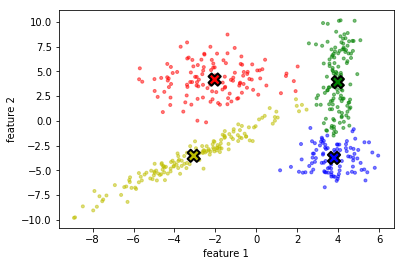

In [1301]:
if __name__ == "__main__":
    
    # Loading datasets
    train_data = np.loadtxt('hwk4data/EMGaussian.train')
    test_data = np.loadtxt('hwk4data/EMGaussian.test')
    
    # Number 2
    #fake_parameters_inference(test_data, plot=True)
    
    # Number 5
    #show_log_likelihood(train_data, test_data, plot=True)
    
    # Number 6
    #make_table_log_likelihood(train_data, test_data, table=True)
    
    # Number 8
    viterbi_plot_data(train_data, plot=True)
    
    # Numbers 9 & 10
    #real_parameters_inference(train_data, test_data, plot=True)
    
    # Number 10
    #viterbi_ml_sequence_plot(train_data, test_data, plot=True)

    